#Preparation

In [1]:
# Allow Collab to connect to your Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the data on Drive
root = "/content/drive/MyDrive/PhD/Integrated_Gradient"


Mounted at /content/drive


In [2]:
!pip install torchsummary

In [3]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import os, time, math, copy
import numpy as np
from scipy.stats import spearmanr
from math import floor


In [4]:
# Checking if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
print("Found:",torch.cuda.device_count(), device)


Found: 1 cuda


In [5]:
# Load the test MNIST dataset
def get_mnist_dataloaders(val_percentage = 0.1, batch_size = 1, shuffle = False):
    dataset_test = datasets.MNIST(f"{root}/dataset", train=False,  download=True, transform=transforms.ToTensor())
    data_loader_test  = DataLoader(dataset_test,  batch_size = batch_size, shuffle = shuffle, num_workers = 2)

    return data_loader_test, len(dataset_test)
    

In [6]:
class CNN(nn.Module):
    """Small sized network """    
    def __init__(self, name, map = 5, stride = 1):
        self.name = name
        fc_output_size  = 50
        map_size        = map   #(3,5,7,9,11,...)
        block1_features = 25
        block2_features = 50
        stride          = stride
        
        super().__init__()

        # Activation function
        if self.name.split("_")[0] == "smooth":
            self.a = torch.nn.Softplus()
        else: 
            self.a = torch.nn.ReLU()

        # Conv block 1
        self.conv1 = nn.Conv2d(1, block1_features, map_size, padding = 1, stride = stride)
        fc_input_size = np.floor((28 - map_size +2 * 1) / stride + 1)     

        # Max pooling
        fc_input_size /= 2
        
        # Conv block 2
        self.conv3 = nn.Conv2d(block1_features, block2_features, map_size, padding = 1, stride = stride)
        fc_input_size = np.floor((-map_size + 2 * 1 + fc_input_size) / stride + 1)  

        # Max pooling
        fc_input_size /= 2
        
        # Fully connected layers
        self.fc1 = nn.Linear(block2_features * int(fc_input_size) ** 2, fc_output_size)
        self.fc2 = nn.Linear(fc_output_size, 10)        

    def forward(self, x):
        x = self.a(self.conv1(x))
        x = F.max_pool2d(x, 2)    
        x = self.a(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)       
        x = self.a(self.fc1(x))
        x = self.fc2(x)

        return x
        

In [7]:
# Load trained model
model = CNN("smooth_CNN").to(device)
model.load_state_dict(torch.load(f"{root}/models/{model.name}.pt", map_location=torch.device(device)))
model.eval()


CNN(
  (a): Softplus(beta=1, threshold=20)
  (conv1): Conv2d(1, 25, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(25, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1250, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## Manifold Integrated Gradient

In [8]:
class ConvVAE(nn.Module):
    def __init__(self):
        self.name = "Conv_VAE"
        super(ConvVAE, self).__init__()
        kernel_size      = 4   # (4 x 4)
        stride           = 2
        padding          = 1
        init_channels    = 16 # initial number of filters
        self.latent_dim  = 20 # latent dimension for sampling

        # Encoder
        # Conv1
        self.enc1 = nn.Conv2d(in_channels = 1, out_channels = init_channels, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = floor((28 - kernel_size  + 2 * padding) / stride + 1)

        # Conv2
        self.enc2 = nn.Conv2d(in_channels = init_channels, out_channels = init_channels * 2, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = floor((height_width - kernel_size  + 2 * padding) / stride + 1)

        # Conv3
        self.enc3 = nn.Conv2d(in_channels = init_channels * 2, out_channels = init_channels * 4, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = floor((height_width - kernel_size  + 2 * padding) / stride + 1)
        
        # fully connected layers for learning representations
        hidden_size = height_width ** 2 * init_channels * 4
        self.fc_mu = nn.Linear(hidden_size, self.latent_dim)
        self.fc_log_var = nn.Linear(hidden_size, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, init_channels * 4)
        
        

        # Decoder
        # ConvT  get width/height equal to kernel_size
        self.dec1 = nn.ConvTranspose2d(in_channels = init_channels * 4, out_channels = init_channels * 4, kernel_size = kernel_size, stride = 1, padding = 0)
        height_width = kernel_size
        
        # ConvT
        self.dec2 = nn.ConvTranspose2d(in_channels = init_channels * 4, out_channels = init_channels * 2, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = (height_width - 1) * stride - 2 * padding + kernel_size
        
        # ConvT
        self.dec3 = nn.ConvTranspose2d(in_channels = init_channels * 2, out_channels = init_channels, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = (height_width - 1) * stride - 2 * padding + kernel_size
        
        # ConvT adjust the padding so that we end up at 28x28
        required_padding = int(((height_width - 1) * stride + kernel_size - 28) / 2) 
        self.dec4 = nn.ConvTranspose2d(in_channels = init_channels, out_channels = 1, kernel_size = kernel_size, stride = stride, padding = required_padding)


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        return mu + eps * std # sampling
        

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        hidden = x.view(x.shape[0], -1)
        return self.fc_mu(hidden), self.fc_log_var(hidden)


    def decode(self, z):
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return torch.sigmoid(self.dec4(x))


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [9]:
vae = ConvVAE().to(device)
vae.load_state_dict(torch.load(root + '/models/Conv_VAE.pt', map_location=torch.device(device)))
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 26, 26]             650
          Softplus-2           [-1, 25, 26, 26]               0
            Conv2d-3           [-1, 50, 11, 11]          31,300
          Softplus-4           [-1, 50, 11, 11]               0
            Linear-5                   [-1, 50]          62,550
          Softplus-6                   [-1, 50]               0
            Linear-7                   [-1, 10]             510
Total params: 95,010
Trainable params: 95,010
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 0.36
Estimated Total Size (MB): 0.72
----------------------------------------------------------------


In [41]:
def IG_manifold_saliency(x, x_baseline, model, n_steps = 200):

    output = model(x)

    with torch.no_grad():
        probs = F.softmax(output, dim = -1)
        pred = torch.argmax(output).item()
    
    alpha = torch.linspace(0, 1, n_steps).to(device)

    # spherical linear interpolation (slerp)
    def slerp(z1, z2, alpha):
        omega = torch.acos(torch.sum(z1 / torch.norm(z1, dim = -1, keepdim = True) \
                                * z2 / torch.norm(z2, dim = -1, keepdim = True), dim = -1, keepdims = True))
        so = torch.sin(omega)
        return torch.cat([torch.sin((1 - a) * omega) / so * z1 + torch.sin(a * omega) / so * z2 for a in alpha]), omega


    z, _ = vae.encode((torch.cat([x_baseline, x], dim = 0) + 1) / 2)
    slerp_z_interp, _ = slerp(z[[0]], z[[1]], alpha)
    spherical_interp = vae.decode(slerp_z_interp).detach()

    # Forward pass
    spherical_interp.requires_grad = True
    output = model(spherical_interp)
    probs = F.softmax(output, dim = -1)
    probs[:, pred].sum().backward()
    model.zero_grad()

    # Compute Integrated Gradient
    partial_attribution = torch.zeros(spherical_interp.shape).to(device)
    diff = torch.diff(spherical_interp, dim = 0) / 2
    partial_attribution[:-1, :] += spherical_interp.grad[:-1, :] * diff
    partial_attribution[1:, :] += spherical_interp.grad[1:, :] * diff

    return pred, probs.detach(), spherical_interp.detach(), partial_attribution.detach()
    

In [42]:
# Load a SPECIFIC instance
dataset_test = datasets.MNIST(f"{root}/dataset", train=False,  download=True, transform=transforms.ToTensor())
# 0 4
# 1 5
# 2 6
i = 0
x, y = dataset_test[i]
x_baseline, y_baseline = dataset_test[i + 4]
x = x.to(device)
x = 2 * x - 1
x = x.unsqueeze(0)

x_baseline = x_baseline.to(device)
x_baseline = 2 * x_baseline - 1
x_baseline = x_baseline.unsqueeze(0)


In [43]:
pred, probs, path, partial_attribution = IG_manifold_saliency(x, x_baseline, model)
print(probs[-1, pred] - probs[0, pred])
partial_attribution.sum()


tensor(0.9906, device='cuda:0')


tensor(0.9900, device='cuda:0')

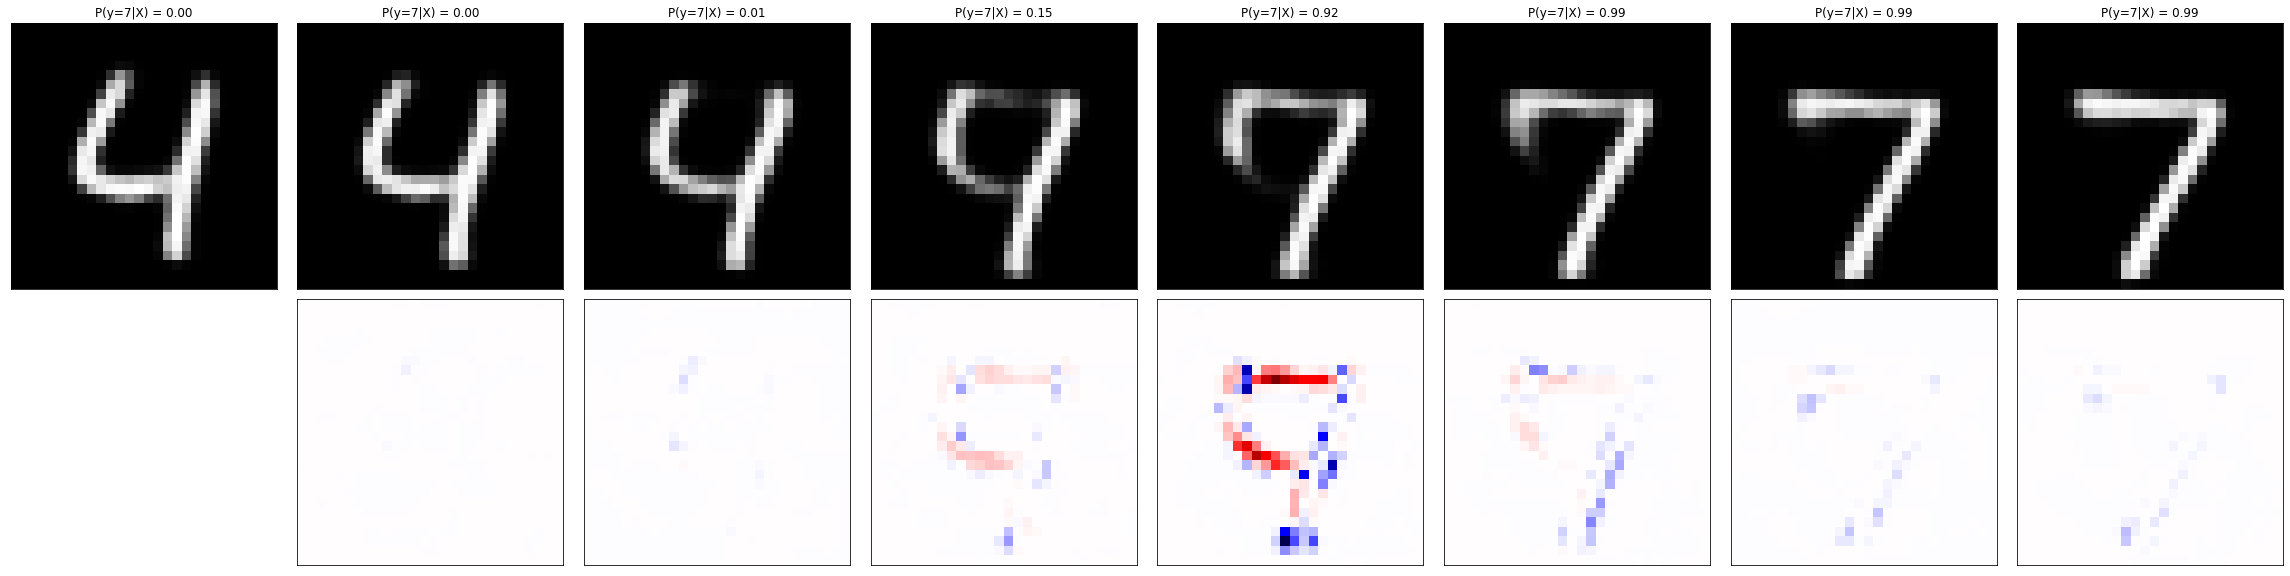

In [66]:
num_row = 2
num_col = 8
num_images = num_row * num_col

# All partial contributions
fig, axes = plt.subplots(num_row, num_col, figsize=(4 * num_col,4 * num_row))
step = int(200 / num_col)

# Compute the partial attribution on each step
step_attribution = partial_attribution[1:(num_col - 1) * step + 1, :].view(num_col - 1, step, 28, 28).sum(dim = 1)

min = step_attribution.min()
max = step_attribution.max()

for i in range(num_col):
    # Plot digit
    ax = axes[0, i]
    ax.imshow(path[i * step, :].cpu().numpy().squeeze().reshape(28, 28), cmap='gray')
    ax.set_title(f"P(y={pred}|X) = {probs[i * step, pred]:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])

    # Plot attribution
    if not i == 0:
        ax = axes[1, i]
        ax.imshow(step_attribution[i - 1, :].cpu().numpy(), cmap = 'seismic', norm = TwoSlopeNorm(0, min, max))
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(f"{root}/results/MIG/{model.name}_{y_baseline}_to_{y}_manifold.pdf", bbox_inches='tight')
plt.show()

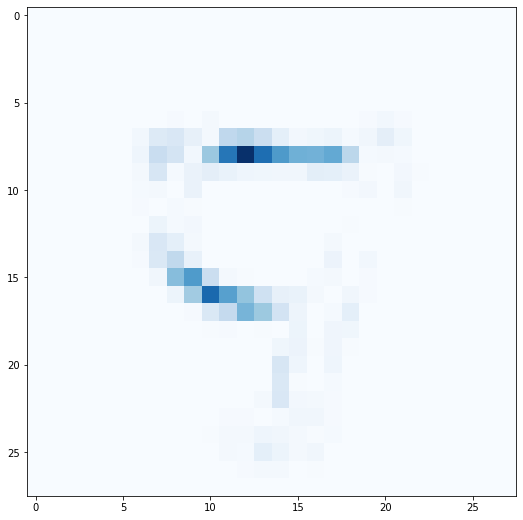

In [47]:
IG = partial_attribution.sum(dim = 0).squeeze()

plt.figure(figsize = (9, 9))
plt.imshow(torch.abs(partial_attribution.sum(dim = 0)).cpu().squeeze(), cmap = 'Blues')


## Average MIG

In [48]:
# Class specific MNIST
class Class_MNIST(torch.utils.data.Dataset):
    def __init__(self, baseline_class, MNIST):
        super(torch.utils.data.Dataset, self).__init__()
        self.parent = MNIST
        self.idx = torch.where(MNIST.targets == baseline_class)[0]
        
    def __len__(self):
         return len(self.idx)
        
    def __getitem__(self, index):
        return self.parent[self.idx[index]]


In [53]:
# Load SPECIFIC instances 7
dataset_test = datasets.MNIST(f"{root}/dataset", train=False,  download=True, transform=transforms.ToTensor())
i = 0  # 0, 1 or 2
x, y = dataset_test[i]
x = x.to(device)
x = 2 * x - 1
x = x.unsqueeze(0)


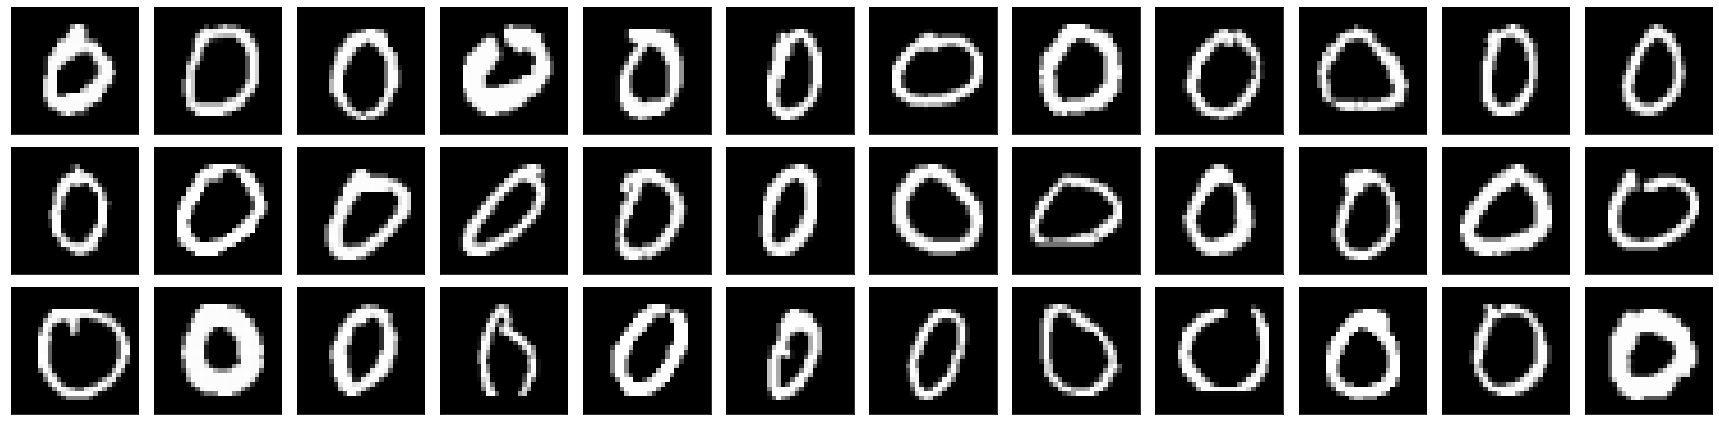

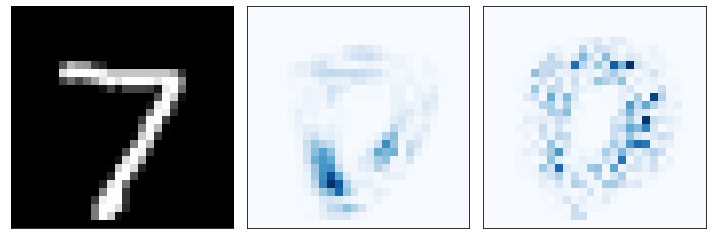

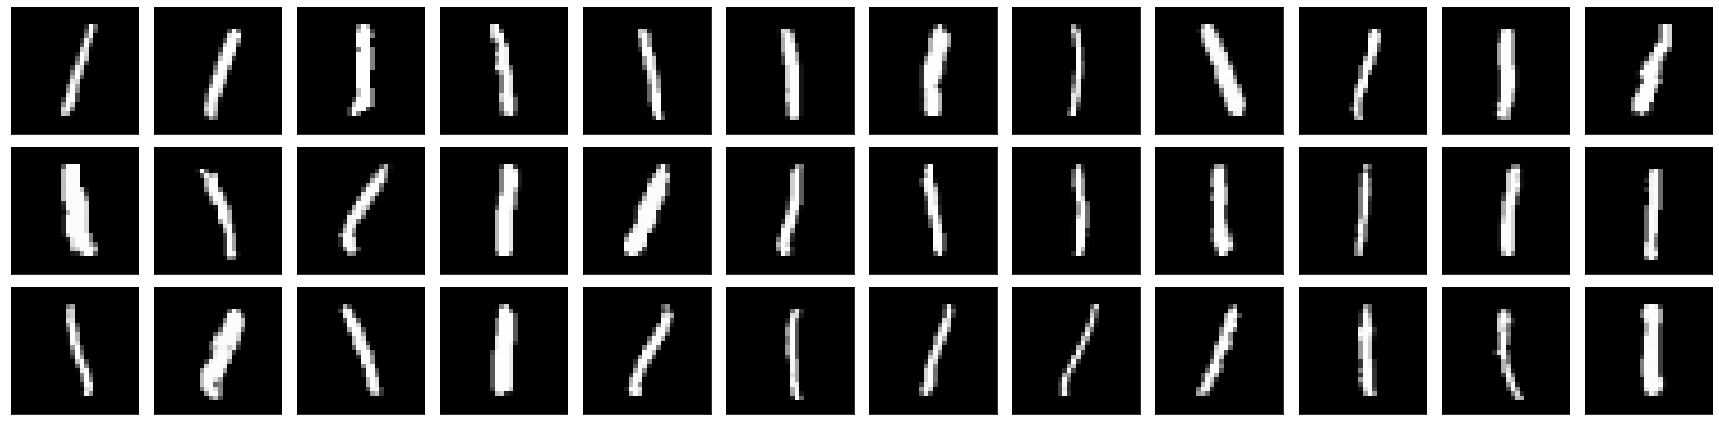

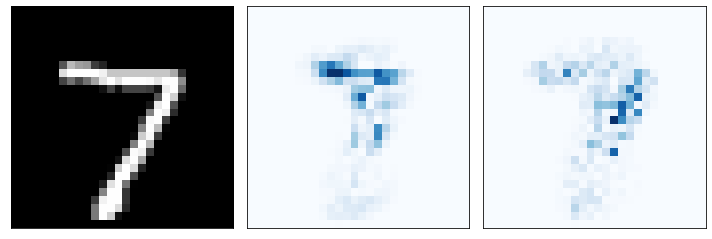

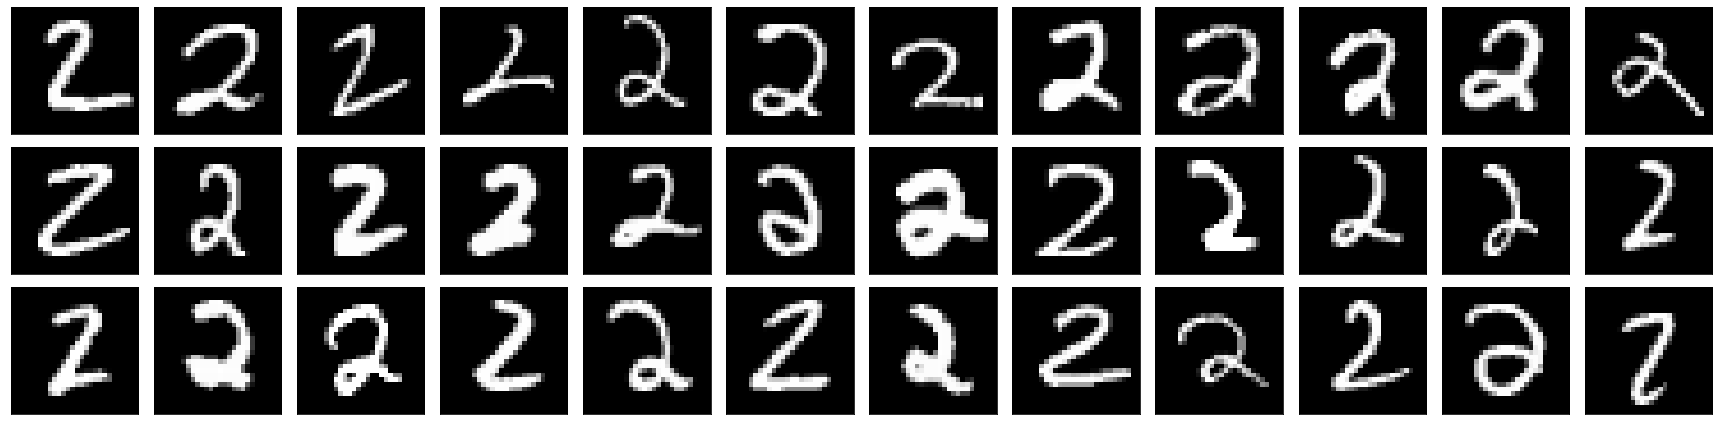

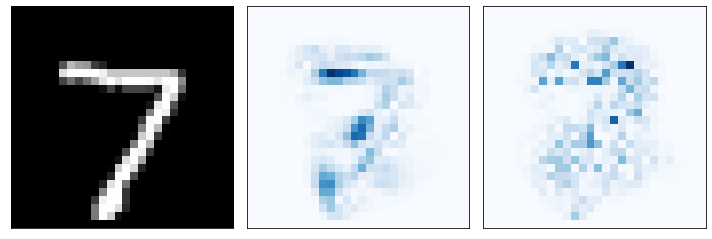

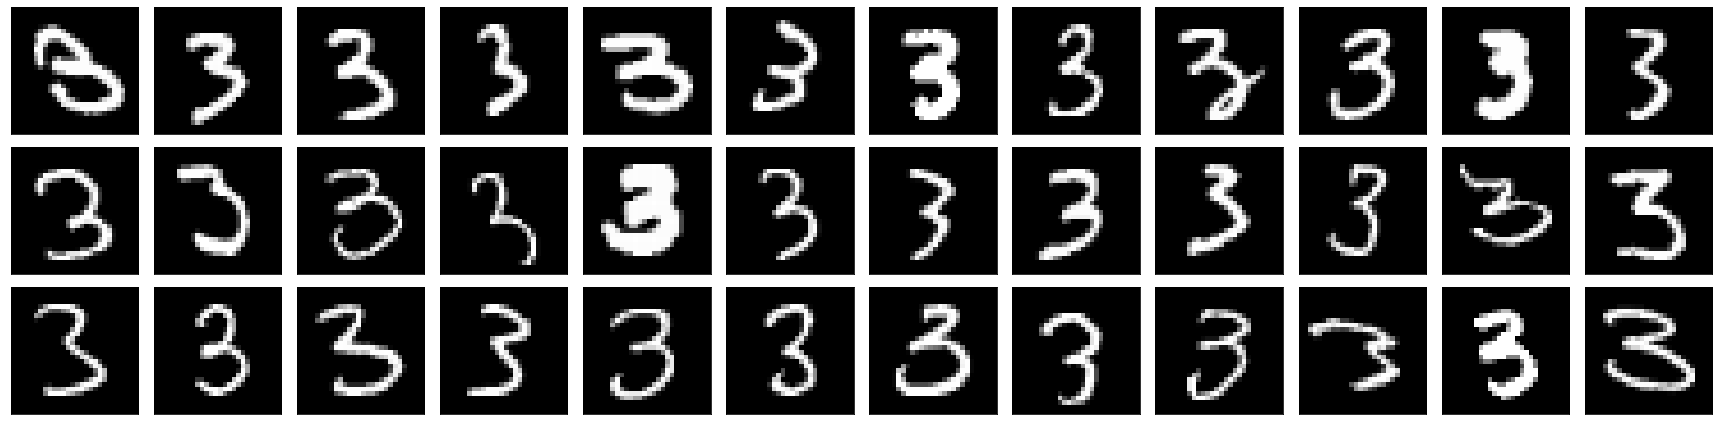

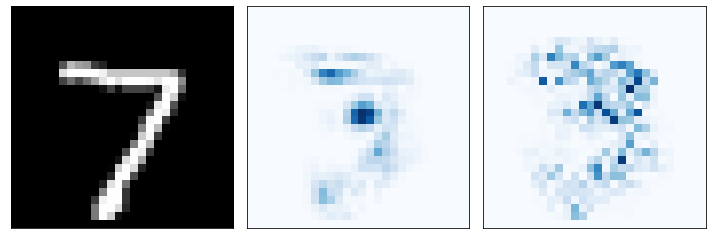

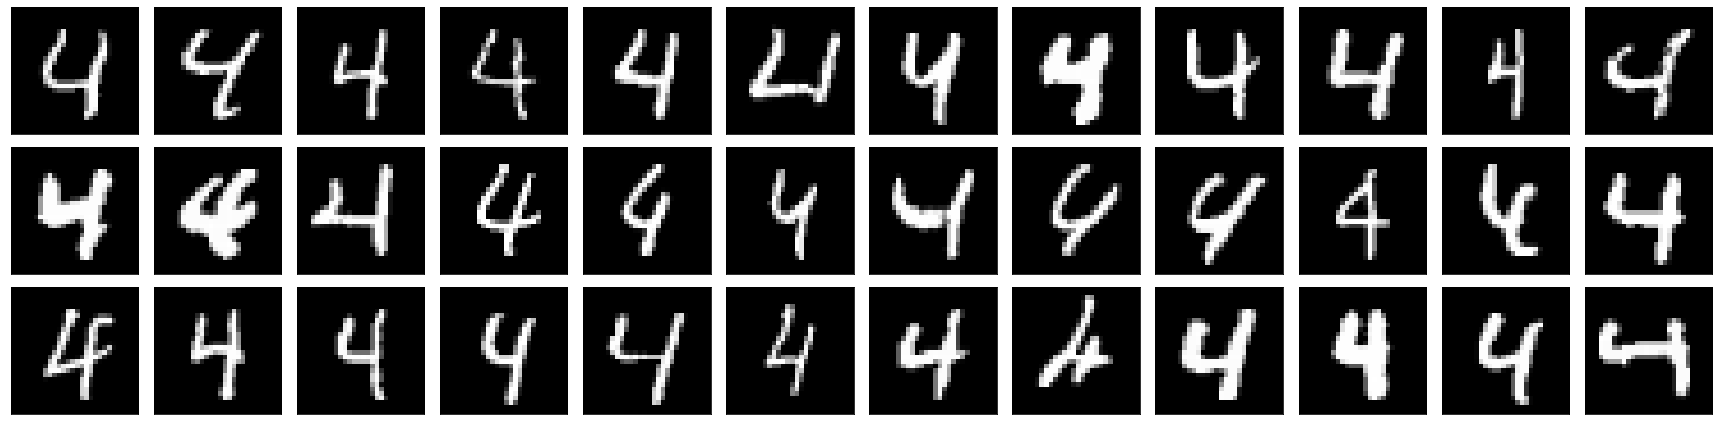

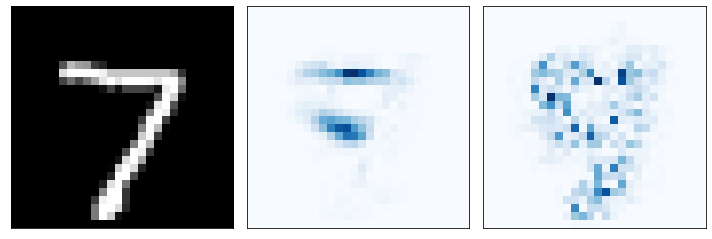

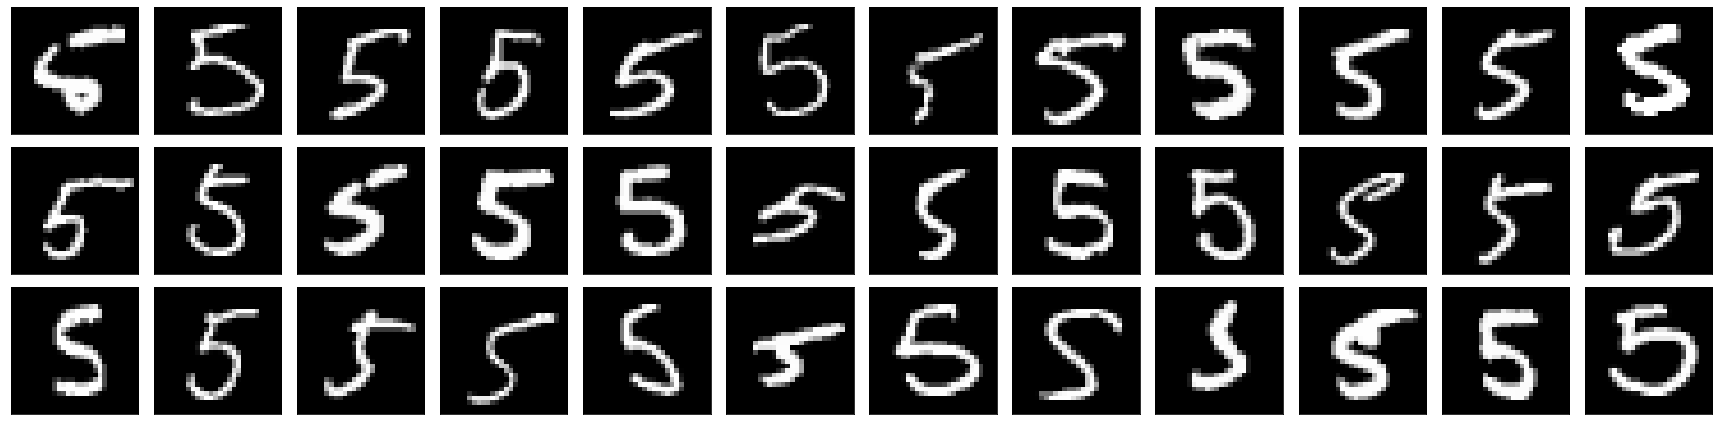

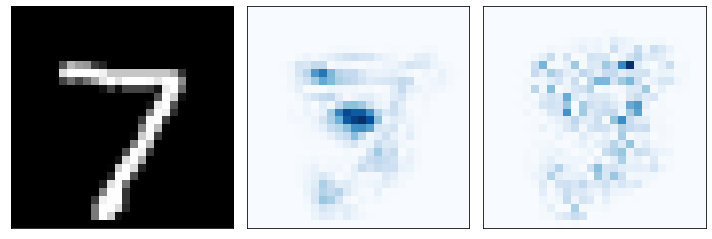

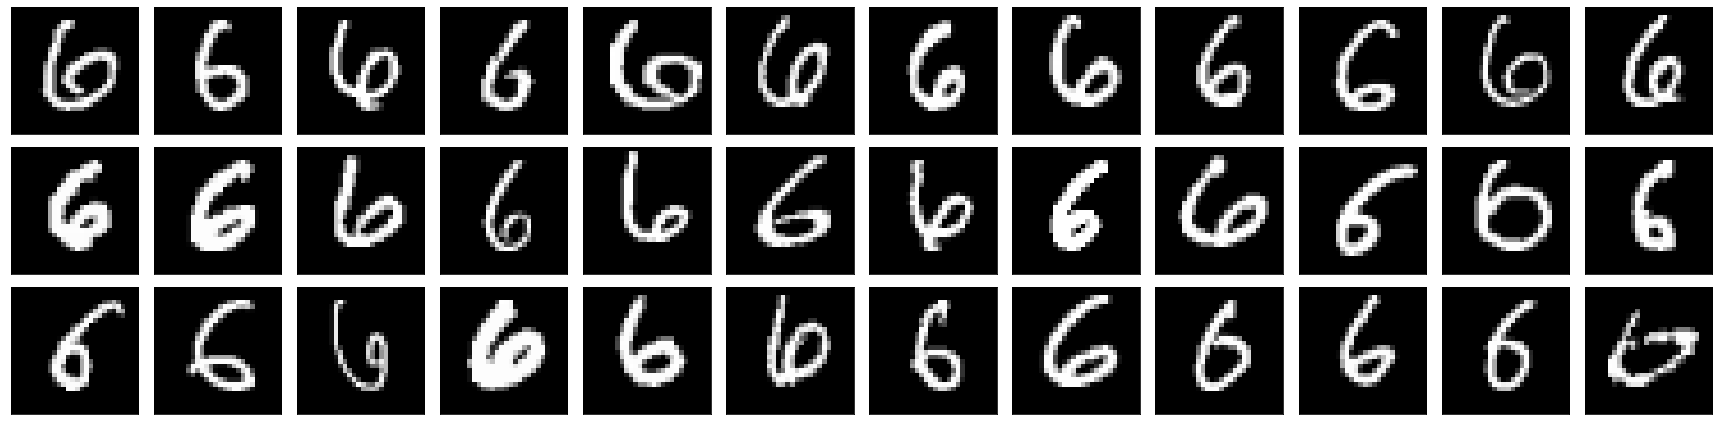

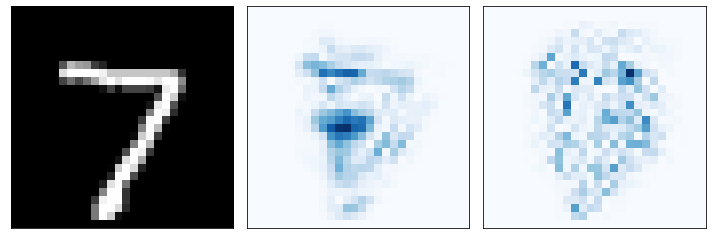

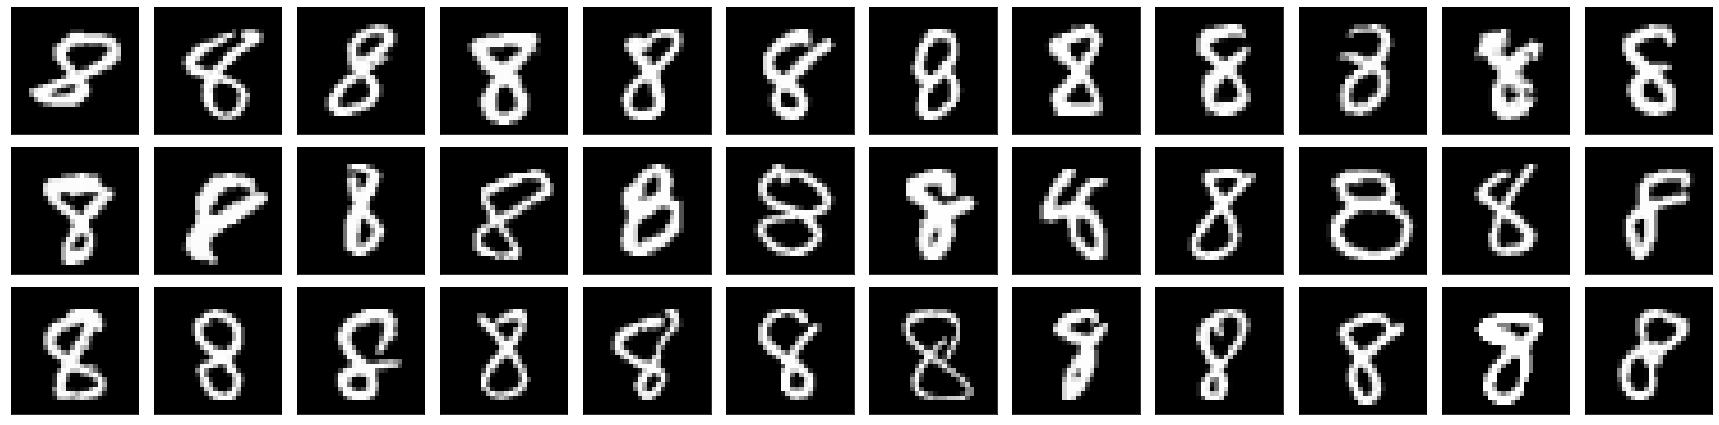

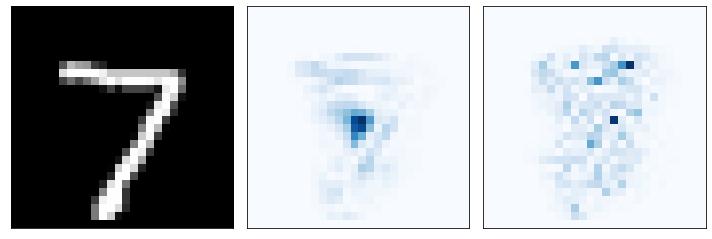

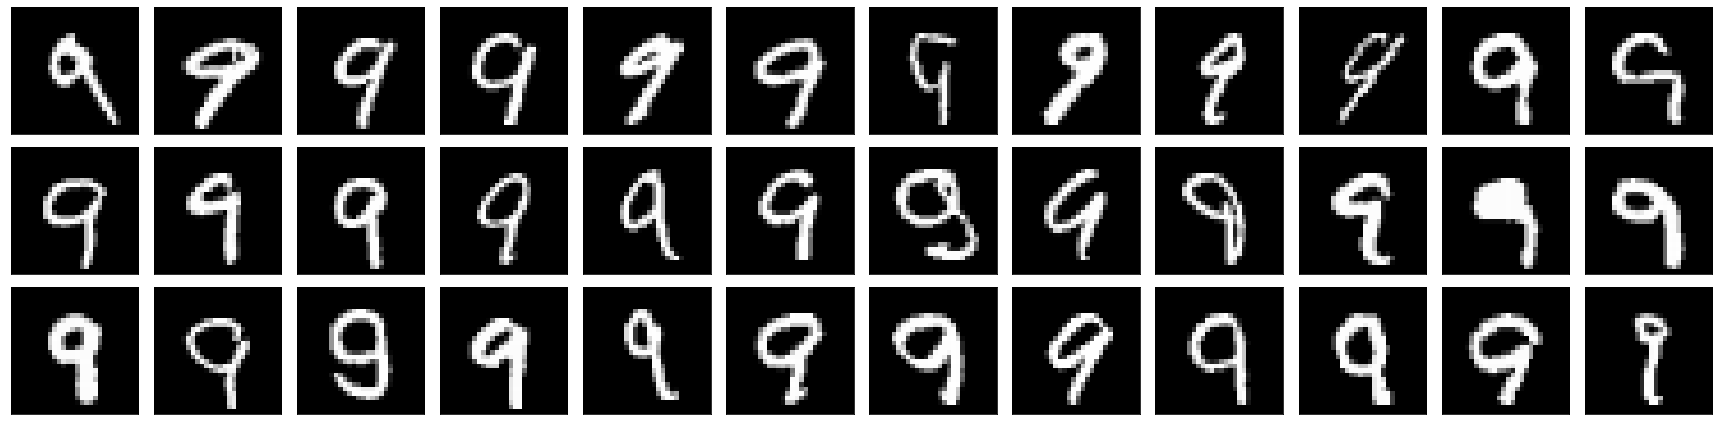

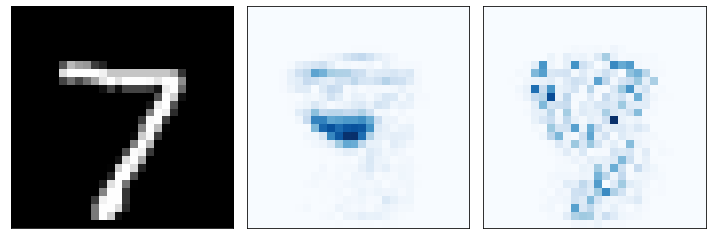

In [58]:
# Mean IG with several baselines of the same class
def AMIG_explainer(x_explain, baseline_class, model, model_rand, num_baselines = 16):
    # Get class
    class_specific_dataset = Class_MNIST(baseline_class, dataset_test)
    data_loader_class = DataLoader(class_specific_dataset,  batch_size = 1, shuffle = False, num_workers = 2)
    
    # Plot baselines
    num_col = int(np.sqrt(num_baselines)) * 2
    num_row = int(num_baselines / num_col)
    fig, axes = plt.subplots(num_row, num_col, figsize=(2* num_col,2*num_row))
    for i, (x_baseline, y) in enumerate(data_loader_class):
        if i >= num_baselines:
            break
        ax = axes[i // num_col, i % num_col]
        ax.imshow(x_baseline.numpy().squeeze(), cmap = "gray")
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.tight_layout()
    plt.show()


    # AIG
    fig, axes = plt.subplots(1, 3, figsize = (10, 30))
    axes[0].imshow(x_explain.cpu().numpy().squeeze(), cmap = "gray")
    axes[0].set_xticks([])
    axes[0].set_yticks([])

    # Compute Average IG
    AIG = torch.zeros(28, 28).to(device)
    AIG_rand = torch.zeros(28, 28).to(device)
    for i, (x_baseline, y) in enumerate(data_loader_class):
        if i >= num_baselines:
            break
        # Normalize
        x_baseline = 2 * x_baseline - 1
        x_baseline = x_baseline.to(device)
        _, _, _, partial_attribution = IG_manifold_saliency(x_explain, x_baseline, model)
        AIG += partial_attribution.sum(dim = 0).squeeze()
        _, _, _, partial_attribution = IG_manifold_saliency(x_explain, x_baseline, model_rand)
        AIG_rand += partial_attribution.sum(dim = 0).squeeze()
    AIG /= num_baselines
    AIG_rand /= num_baselines

    # Clean Model
    axes[1].imshow(torch.abs(AIG).cpu(), cmap = 'Blues')
    axes[1].set_xticks([])
    axes[1].set_yticks([])

    # Perturbed model
    axes[2].imshow(torch.abs(AIG_rand).cpu(), cmap = 'Blues')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    
    plt.tight_layout()
    plt.show()

def AIG_tests():
    # Create a random model
    model_rand = CNN("smooth_CNN_mixup").to(device)

    for i in range(10):
        if not i == 7:
            AMIG_explainer(x, i, model, model_rand, 36)

AIG_tests()

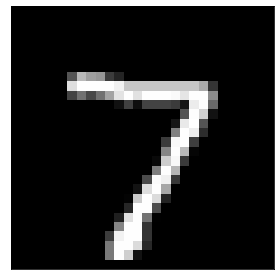

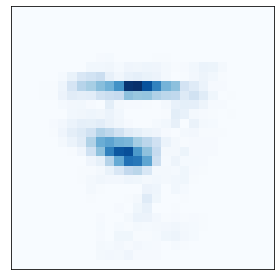

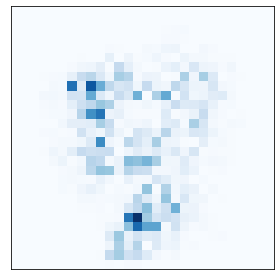

In [68]:
# Mean IG with several baselines of the same class
def AMIG_explainer_save_plots(x_explain, baseline_class, model, model_rand, num_baselines = 16):
    # Get class
    class_specific_dataset = Class_MNIST(baseline_class, dataset_test)

    # Show baselines
    #data_loader_class = DataLoader(class_specific_dataset,  batch_size = num_baselines, shuffle = False, num_workers = 2)
    #save_image(next(iter(data_loader_class))[0], f"{root}/results/IG/baselines_{baseline_class}.png", nrow = 12)


    # AIG
    data_loader_class = DataLoader(class_specific_dataset,  batch_size = 1, shuffle = False, num_workers = 2)
    
    # X input
    plt.figure()
    plt.imshow(x_explain.cpu().numpy().squeeze(), cmap = "gray")
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"{root}/results/MIG/7.pdf", bbox_inches='tight')
    plt.show()

    # Compute Average IG
    AIG = torch.zeros(28, 28).to(device)
    AIG_rand = torch.zeros(28, 28).to(device)
    for i, (x_baseline, y) in enumerate(data_loader_class):
        if i >= num_baselines:
            break
        # Normalize
        x_baseline = 2 * x_baseline - 1
        x_baseline = x_baseline.to(device)
        _, _, _, partial_attribution = IG_manifold_saliency(x_explain, x_baseline, model)
        AIG += partial_attribution.sum(dim = 0).squeeze()
        _, _, _, partial_attribution = IG_manifold_saliency(x_explain, x_baseline, model_rand)
        AIG_rand += partial_attribution.sum(dim = 0).squeeze()
    AIG /= num_baselines
    AIG_rand /= num_baselines

    # Clean Model
    plt.figure()
    plt.imshow(torch.abs(AIG).cpu(), cmap = 'Blues')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"{root}/results/MIG/{model.name}_7_AMIG_baseline_{baseline_class}.pdf", bbox_inches='tight')
    plt.show()

    # Perturbed model
    plt.imshow(torch.abs(AIG_rand).cpu(), cmap = 'Blues')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"{root}/results/MIG/random_7_AMIG_baseline_{baseline_class}.pdf", bbox_inches='tight')
    
    plt.show()


# Create a random model
model_rand = CNN("smooth_CNN_mixup").to(device)

AMIG_explainer_save_plots(x, 4, model, model_rand, 36)
